In [1]:
import numpy as np
from vba_like_forward import DCM, f_dcm_w_hrf, g_hrf
from matplotlib import pyplot as plt
from matplotlib import animation
import seaborn as sns

## Figures 

Best save the figures as GIF, it does not show in the jupyter notebook as an animation right now. 

# Most simple DCM

In [12]:
def animate_trajectory(data, axes, filename=None, window_size=100, step_size=1, titles=None,
                      is_hrf=None):
    # Create a figure and axis for the animation

    lines = []

    no_plots = len(axes)

    if is_hrf is None:
        is_hrf = [False] * no_plots


    if titles is None:
        titles = []

    mins = np.min([np.nanmin(da[:, :]) for da in data])
    maxs = np.max([np.nanmax(da[:, :]) for da in data])


    for dat, ax, ish in zip(data, axes, is_hrf):

        local_lim = np.max([np.abs(np.nanmin(dat[:, :])), np.abs(np.nanmax(dat[:, :]))]) + 0.02

        ax.set(ylim=[-local_lim, local_lim])

        if ish=='HRF':
            lines.append(ax.plot(np.arange(0, window_size), dat[:, 0:window_size].T, '*'))

            lines[-1][1].set_linestyle('--')
            lines[-1][1].set_marker('')
            lines[-1][1].set_color('gray')
        elif ish=='xt':
            lines.append(ax.plot(np.arange(0, window_size), dat[:, 0:window_size].T, linestyle='--',
                         color='gray'))
            lines[-1][-1].set_linestyle('-')
            lines[-1][-1].set_color('blue')

        else:
            lines.append(ax.plot(np.arange(0, window_size), dat[:, 0:window_size].T))

        titles.append('')

    # Define the function to update the plot for each frame
    def animate(i):
        # Get the start and end indices for the current window
        start = i * step_size
        end = start + window_size
        tp = np.arange(start, end)

        for da, ax, lin in zip(data, axes, lines):
            window_data = da[:, start:end]

            for ii in range(len(lin)):
                lin[ii].set_ydata(window_data[ii])
                lin[ii].set_xdata(tp)

            # Set the x-axis limits to show the current window
            ax.set_xlim(start, end)
            # Add labels to the plot
            #ax.set_xlabel('Time')
            ax.set_yticklabels(len(ax.get_yticklabels()) * [''])
            ax.set_xticklabels(len(ax.get_xticklabels()) * [''])

            #ax.set_ylabel('Value')
            ax.set_title('')

    anim = animation.FuncAnimation(fig, animate, frames= (nt_micro - window_size) // step_size, interval=30,
                                   blit=True, repeat=True)

    if filename is not None:
        anim.save(filename, writer='pillow')

In [13]:
TR = 2.0
decim = 10
trs = 30
microDT = TR / decim
nt_micro = int((trs * TR) / microDT)

window_size = int(15 / microDT)

stim1_dur = int(2 / microDT) # seconds
stim1_ons = int(20 / microDT)  #

stim2_dur = int(3.5 / microDT) # seconds
stim2_ons = int(25 / microDT)  #

<IPython.core.display.Javascript object>


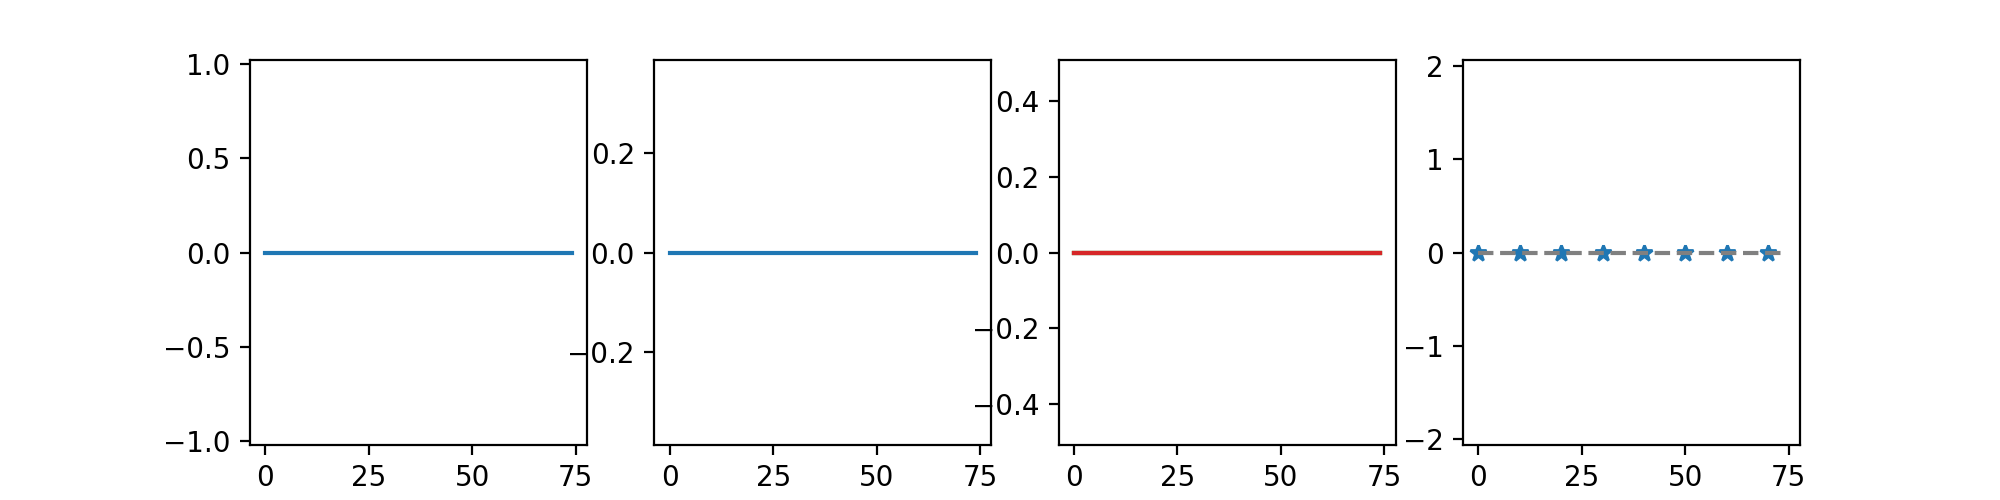

In [14]:
%matplotlib notebook

nreg = 1
nu = 1
u = np.zeros((nu, nt_micro))

u[0, stim1_ons : stim1_ons + stim1_dur ] = 1

tr_index = np.arange(nt_micro)
tr_index = tr_index[::decim]

A = np.zeros((nreg, nreg)).astype(int)
B = np.zeros((nu, nreg, nreg)).astype('int')
C = np.ones((nreg, nu)).astype(int)
D = np.zeros((nreg, nreg, nreg)).astype('int')
dcm = DCM(A, B, C, D, TR, microDT)


theta = np.zeros(dcm.dimensions['theta'])
theta[0] = 1
theta[dcm.evolution['indself']] = 1
theta = theta[:, np.newaxis]


phi = np.zeros(dcm.dimensions['phi'])

gx = np.zeros((nreg, nt_micro))
Xt = np.zeros((dcm.dimensions['n'], nt_micro))


for n, ut in enumerate(u.T):
    if n == 0:
        Xtprev = np.zeros((dcm.dimensions['n'], 1))
    else:
        Xtprev = Xt[:, n-1][:, np.newaxis]
    Xt[:, n] = f_dcm_w_hrf(Xtprev, theta, ut, dcm).ravel()
    gx[:, n] = g_hrf(Xtprev, phi, ut, dcm).ravel()


fig = plt.figure(figsize=(10, 2.5))

shape = (1, 4)
locs = [(0, 0), (0, 1), (0, 2),(0, 3)]
axes = [plt.subplot2grid(shape, lc, rowspan=2) for lc in locs]

gx_plot = np.zeros(gx.shape) * np.nan
gx_plot[:, tr_index] = gx[:, tr_index]

hrf_list = [False, False, False, 'HRF']

animate_trajectory([u[:, :], Xt[4:5, :],Xt[:4, :], np.vstack([gx_plot, gx])],
                   axes, None, is_hrf=hrf_list, window_size=window_size)
plt.show()

<IPython.core.display.Javascript object>


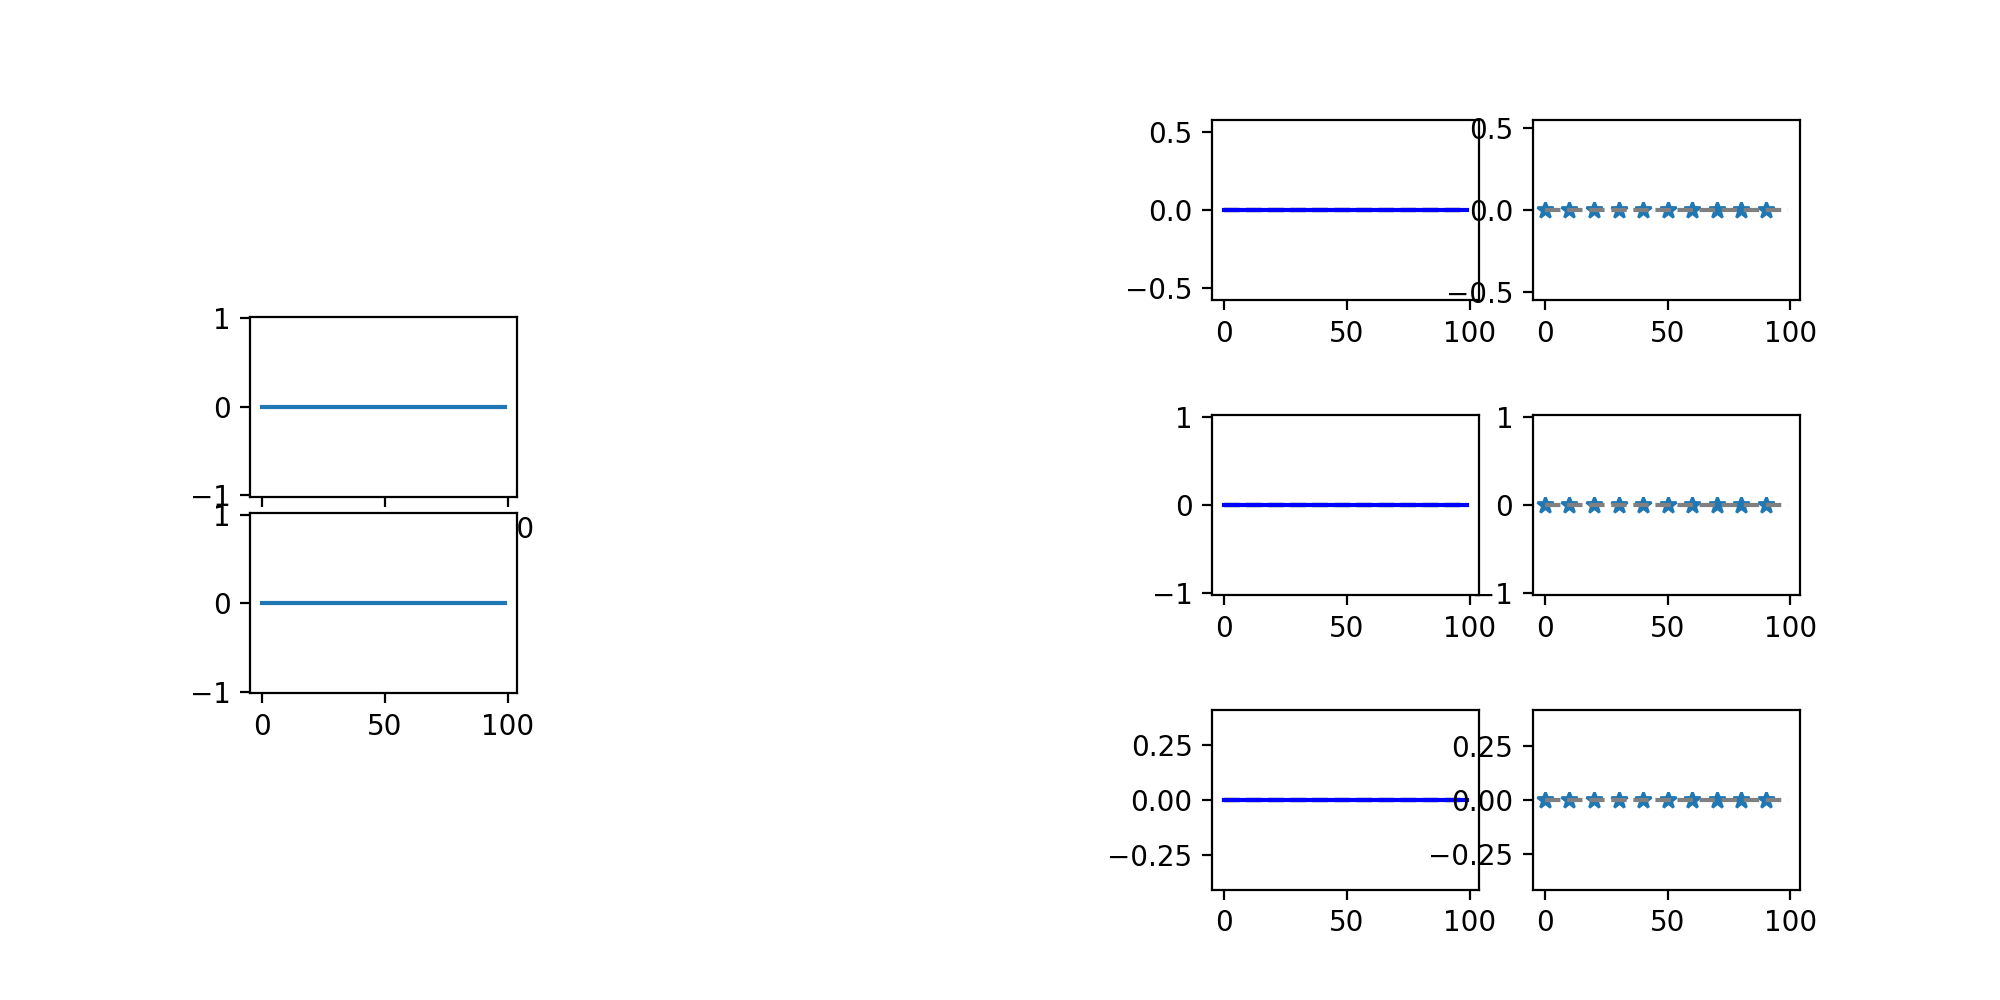

In [15]:
%matplotlib notebook
nreg = 3
nu = 2

u = np.zeros((nu, nt_micro))

u[0, stim1_ons : stim1_ons + stim1_dur ] = 1
u[1, stim2_ons : stim2_ons + stim2_dur ] = 1


tr_index = np.arange(nt_micro)
tr_index = tr_index[::decim]

A = np.zeros((nreg, nreg)).astype(int)
B = np.zeros((nu, nreg, nreg)).astype('int')
C = np.zeros((nreg, nu)).astype(int)

C[0, 0] = 1
C[1, 1] = 1
C[2, 0] = 1
C[2, 1] = 1


D = np.zeros((nreg, nreg, nreg)).astype('int')
dcm = DCM(A, B, C, D, TR, microDT)


theta = np.zeros(dcm.dimensions['theta'])
theta[0] = 1
theta[1] = 1.5
theta[2] = 0.5
theta[3] = 0.5
theta[dcm.evolution['indself']] = 1


theta = theta[:, np.newaxis]
phi = np.zeros(dcm.dimensions['phi'])

gx = np.zeros((nreg, nt_micro))
Xt = np.zeros((dcm.dimensions['n'], nt_micro))


for n, ut in enumerate(u.T):
    if n == 0:
        Xtprev = np.zeros((dcm.dimensions['n'], 1))
    else:
        Xtprev = Xt[:, n-1][:, np.newaxis]
    Xt[:, n] = f_dcm_w_hrf(Xtprev, theta, ut, dcm).ravel()
    gx[:, n] = g_hrf(Xtprev, phi, ut, dcm).ravel()


# 2 + 1 + 2 + 1
# 2 + 2 + 2

fig = plt.figure(figsize=(10, 5))

shape = (8, 5)
locs = [(2, 0), (4, 0), (0, 3), (3, 3),(6, 3), (0, 4), (3, 4), (6, 4)]
axes = [plt.subplot2grid(shape, lc, rowspan=2) for lc in locs]

gx = gx / np.max(np.abs(gx))
Xt = Xt / np.max(np.abs(Xt))
gx_plot = np.zeros(gx.shape) * np.nan
gx_plot[:, tr_index] = gx[:, tr_index]

hrf_list = [False, False, 'xt', 'xt', 'xt', 'HRF', 'HRF', 'HRF',]

animate_trajectory([u[0:1, :], u[1:2, :], Xt[:5, :],Xt[5:10, :], Xt[10:, :],
                    np.vstack([gx_plot[:1, :], gx[:1, :]]),
                    np.vstack([gx_plot[1:2, :], gx[1:2, :]]),
                    np.vstack([gx_plot[2:3, :], gx[2:3, :]])],
                   axes, None, is_hrf=hrf_list)
plt.show()

<IPython.core.display.Javascript object>


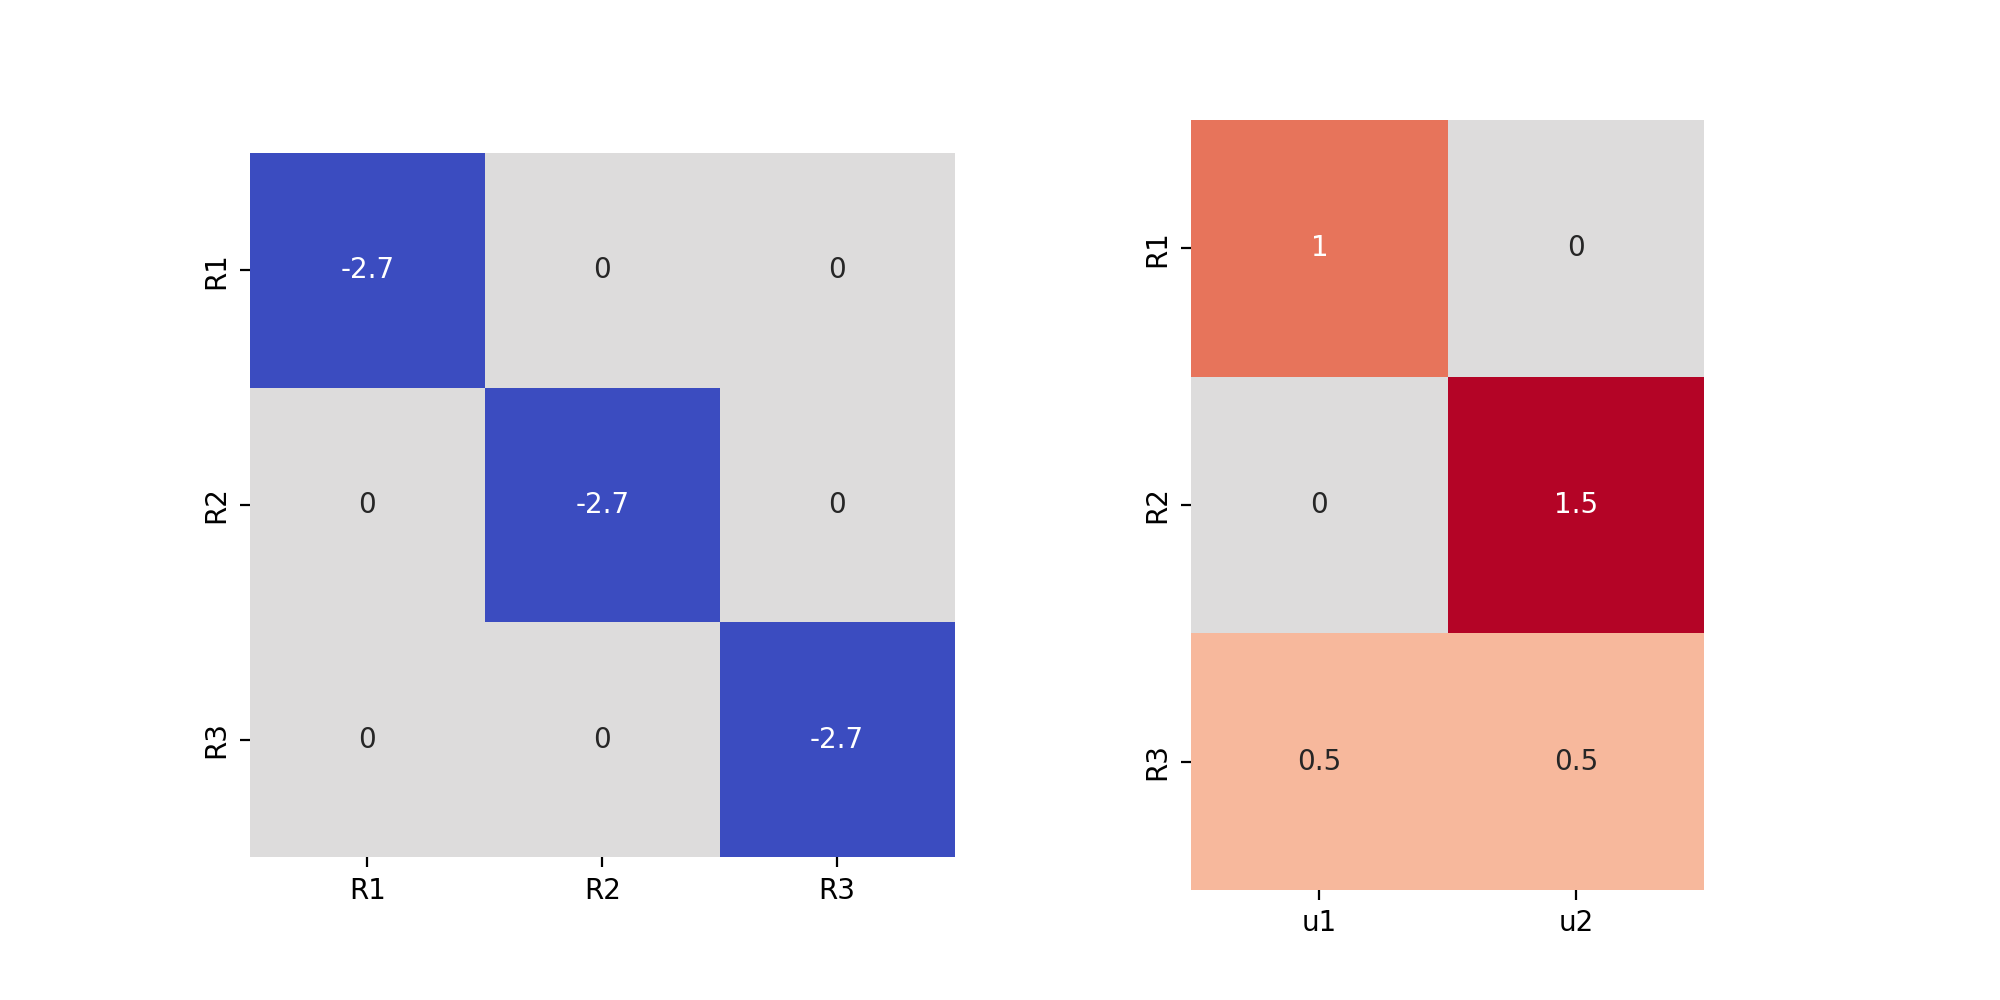

<Axes: >

In [6]:
A, B, C, D = dcm.parameters_to_matrix(theta)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()
sns.heatmap(A, center=0, annot=True, xticklabels=['R1', 'R2', 'R3'],
            yticklabels=['R1', 'R2', 'R3'], cmap='coolwarm', square=True, ax=axes[0], cbar=False)

sns.heatmap(C, center=0, annot=True, xticklabels=['u1', 'u2'],
            yticklabels=['R1', 'R2', 'R3'], cmap='coolwarm', square=True,ax=axes[1], cbar=False)

# plt.savefig('AC_fig2', transparent=True, bbox_inches='tight')

<IPython.core.display.Javascript object>


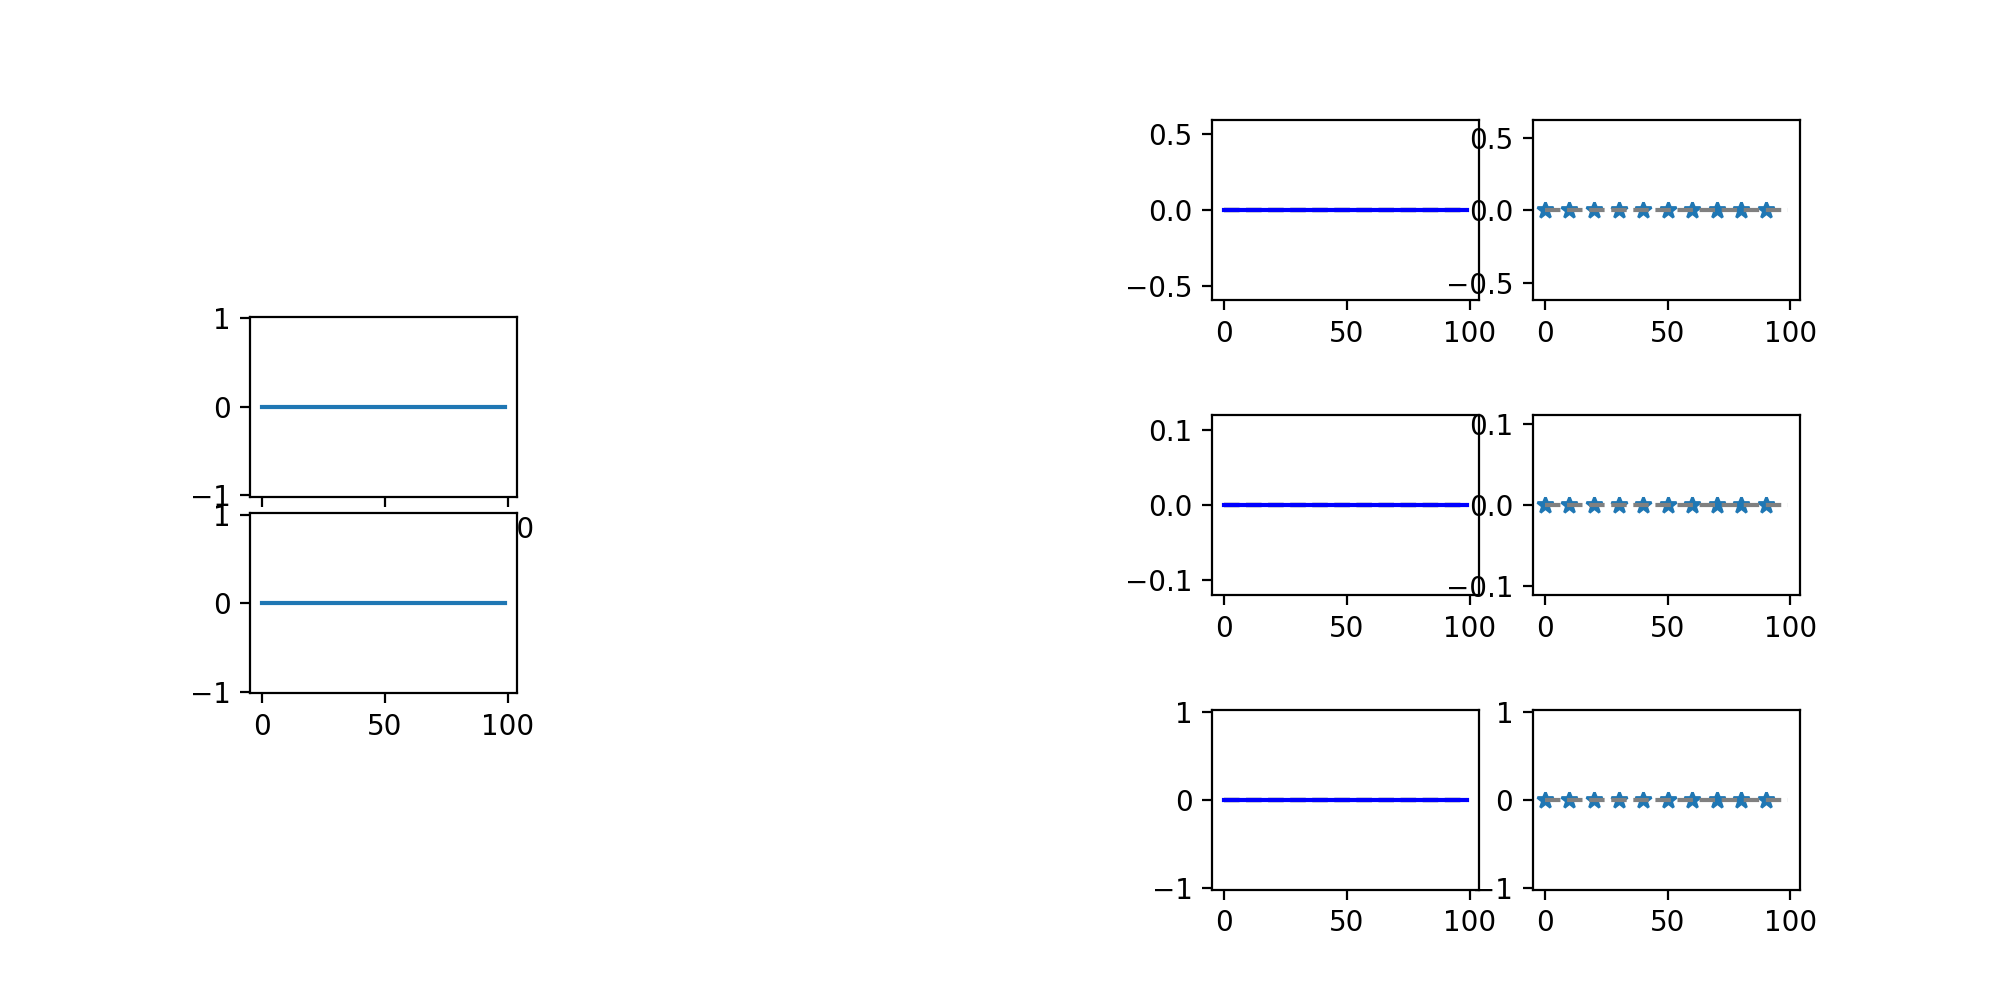

In [16]:
%matplotlib notebook
nreg = 3
nu = 2
stim2_ons = int(25 / microDT)  # stim1_ons + stim1_dur #  int(12 / microDT)  #

u = np.zeros((nu, nt_micro))

u[0, stim1_ons : stim1_ons + stim1_dur ] = 1
u[0, stim2_ons : stim2_ons + stim1_dur]  = 1
u[1, stim2_ons : stim2_ons + stim1_dur ] = 1


tr_index = np.arange(nt_micro)
tr_index = tr_index[::decim]

A = np.zeros((nreg, nreg)).astype(int)
B = np.zeros((nu, nreg, nreg)).astype('int')
C = np.zeros((nreg, nu)).astype(int)


A[1, 0] = 1
A[2, 1] = 1
A[0, 2] = 1
A[1, 2] = 1

B[1, 0, 2] = 1

C[0, 0] = 1
C[2, 0] = 1


D = np.zeros((nreg, nreg, nreg)).astype('int')
dcm = DCM(A, B, C, D, TR, microDT)


theta = np.zeros(dcm.dimensions['theta'])
theta[0] = -0.7
theta[1] = 0.9
theta[2] = -0.3
theta[3] = 0.75
theta[4] = 0.75
theta[5] = 0.5
theta[6] = 0.8

theta[dcm.evolution['indself']] = 1


theta = theta[:, np.newaxis]
phi = np.zeros(dcm.dimensions['phi'])

gx = np.zeros((nreg, nt_micro))
Xt = np.zeros((dcm.dimensions['n'], nt_micro))


for n, ut in enumerate(u.T):
    if n == 0:
        Xtprev = np.zeros((dcm.dimensions['n'], 1))
    else:
        Xtprev = Xt[:, n-1][:, np.newaxis]
    Xt[:, n] = f_dcm_w_hrf(Xtprev, theta, ut, dcm).ravel()
    gx[:, n] = g_hrf(Xtprev, phi, ut, dcm).ravel()


# 2 + 1 + 2 + 1
# 2 + 2 + 2

fig = plt.figure(figsize=(10, 5))

shape = (8, 5)
locs = [(2, 0), (4, 0), (0, 3), (3, 3),(6, 3), (0, 4), (3, 4), (6, 4)]
axes = [plt.subplot2grid(shape, lc, rowspan=2) for lc in locs]

gx = gx / np.max(np.abs(gx))
Xt = Xt / np.max(np.abs(Xt))

gx_plot = np.zeros(gx.shape) * np.nan
gx_plot[:, tr_index] = gx[:, tr_index]

hrf_list = [False, False, 'xt', 'xt', 'xt', 'HRF', 'HRF', 'HRF',]

animate_trajectory([u[0:1, :], u[1:2, :], Xt[:5, :],Xt[5:10, :], Xt[10:, :],
                    np.vstack([gx_plot[:1, :], gx[:1, :]]),
                    np.vstack([gx_plot[1:2, :], gx[1:2, :]]),
                    np.vstack([gx_plot[2:3, :], gx[2:3, :]])],
                   axes, None, is_hrf=hrf_list)
#plt.show()

<IPython.core.display.Javascript object>


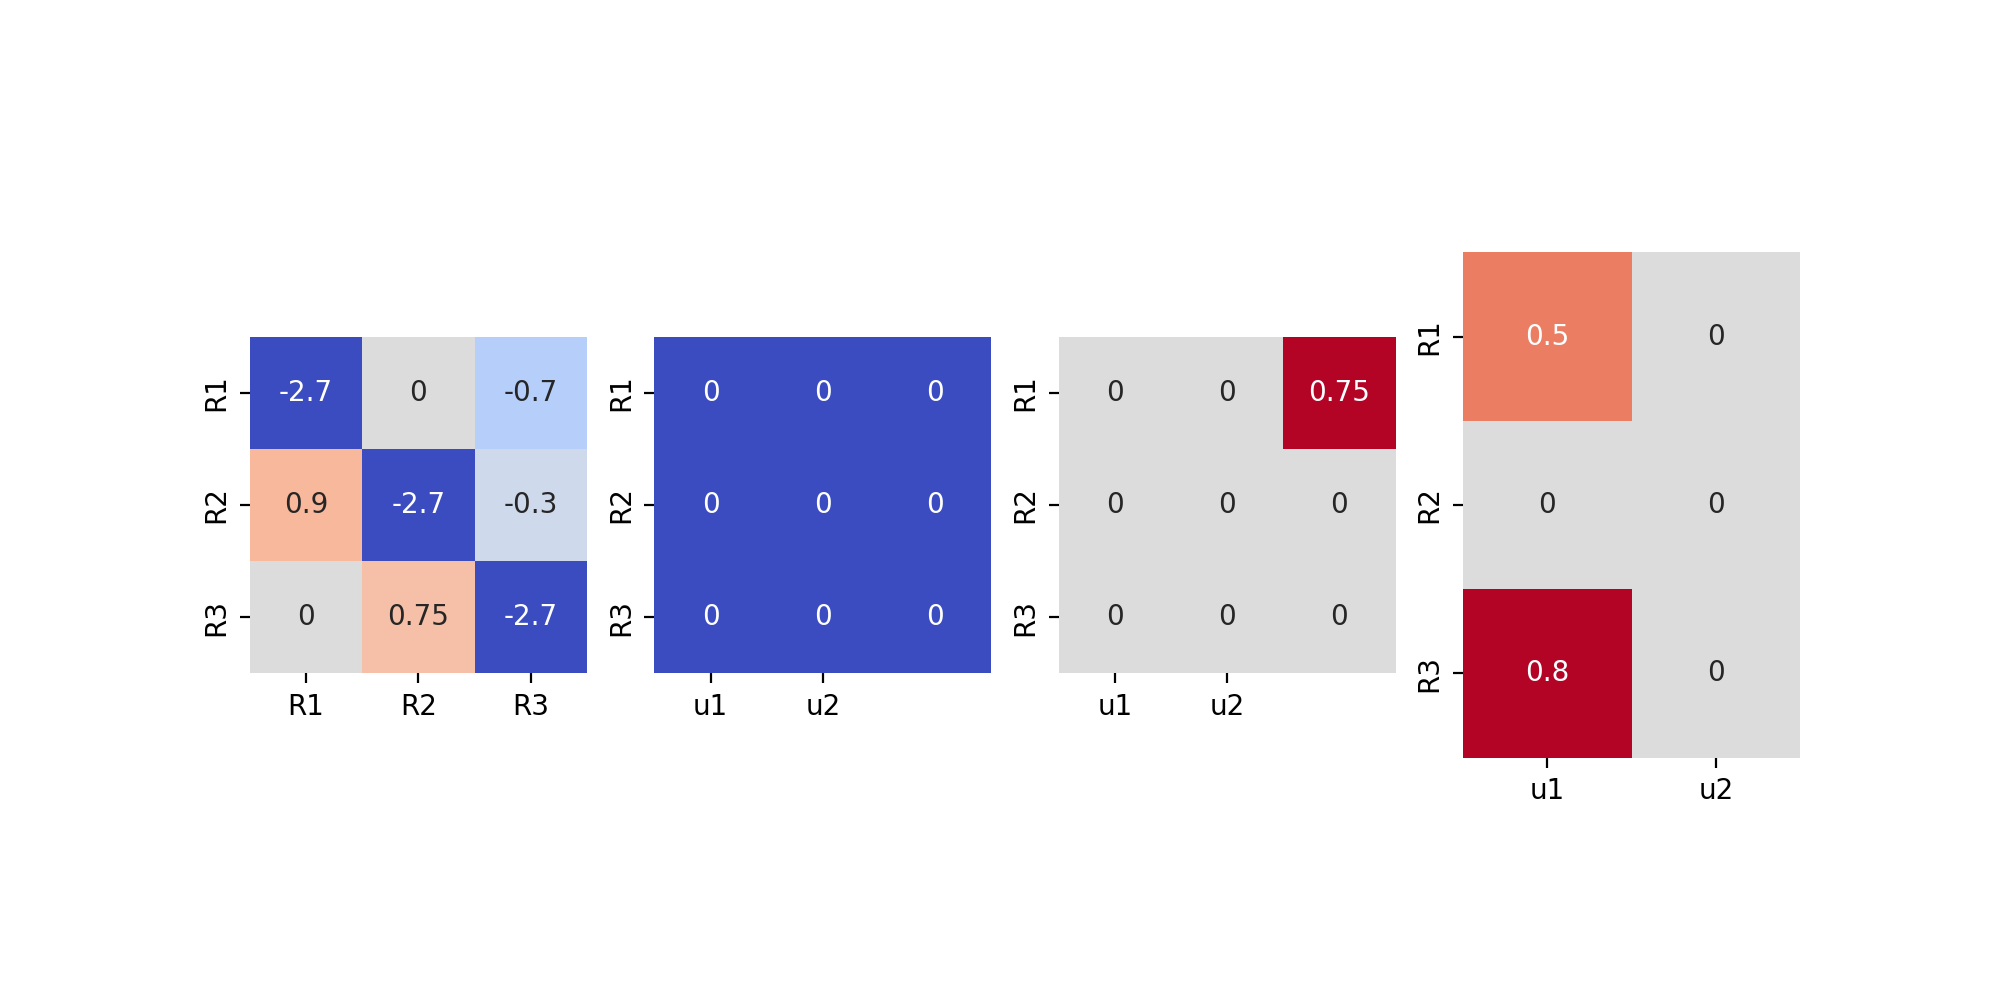

<Axes: >

In [8]:
A, B, C, D = dcm.parameters_to_matrix(theta)

fig, axes = plt.subplots(1, 4, figsize=(10, 5))
axes = axes.flatten()
sns.heatmap(A, center=0, annot=True, xticklabels=['R1', 'R2', 'R3'],
            yticklabels=['R1', 'R2', 'R3'], cmap='coolwarm', square=True, ax=axes[0], cbar=False)

sns.heatmap(B[0], center=0, annot=True, xticklabels=['u1', 'u2'],
            yticklabels=['R1', 'R2', 'R3'], cmap='coolwarm', square=True,ax=axes[1], cbar=False)

sns.heatmap(B[1], center=0, annot=True, xticklabels=['u1', 'u2'],
            yticklabels=['R1', 'R2', 'R3'], cmap='coolwarm', square=True,ax=axes[2], cbar=False)


sns.heatmap(C, center=0, annot=True, xticklabels=['u1', 'u2'],
            yticklabels=['R1', 'R2', 'R3'], cmap='coolwarm', square=True,ax=axes[3], cbar=False)

#plt.savefig('ABBC_fig3', transparent=True, bbox_inches='tight')

<IPython.core.display.Javascript object>


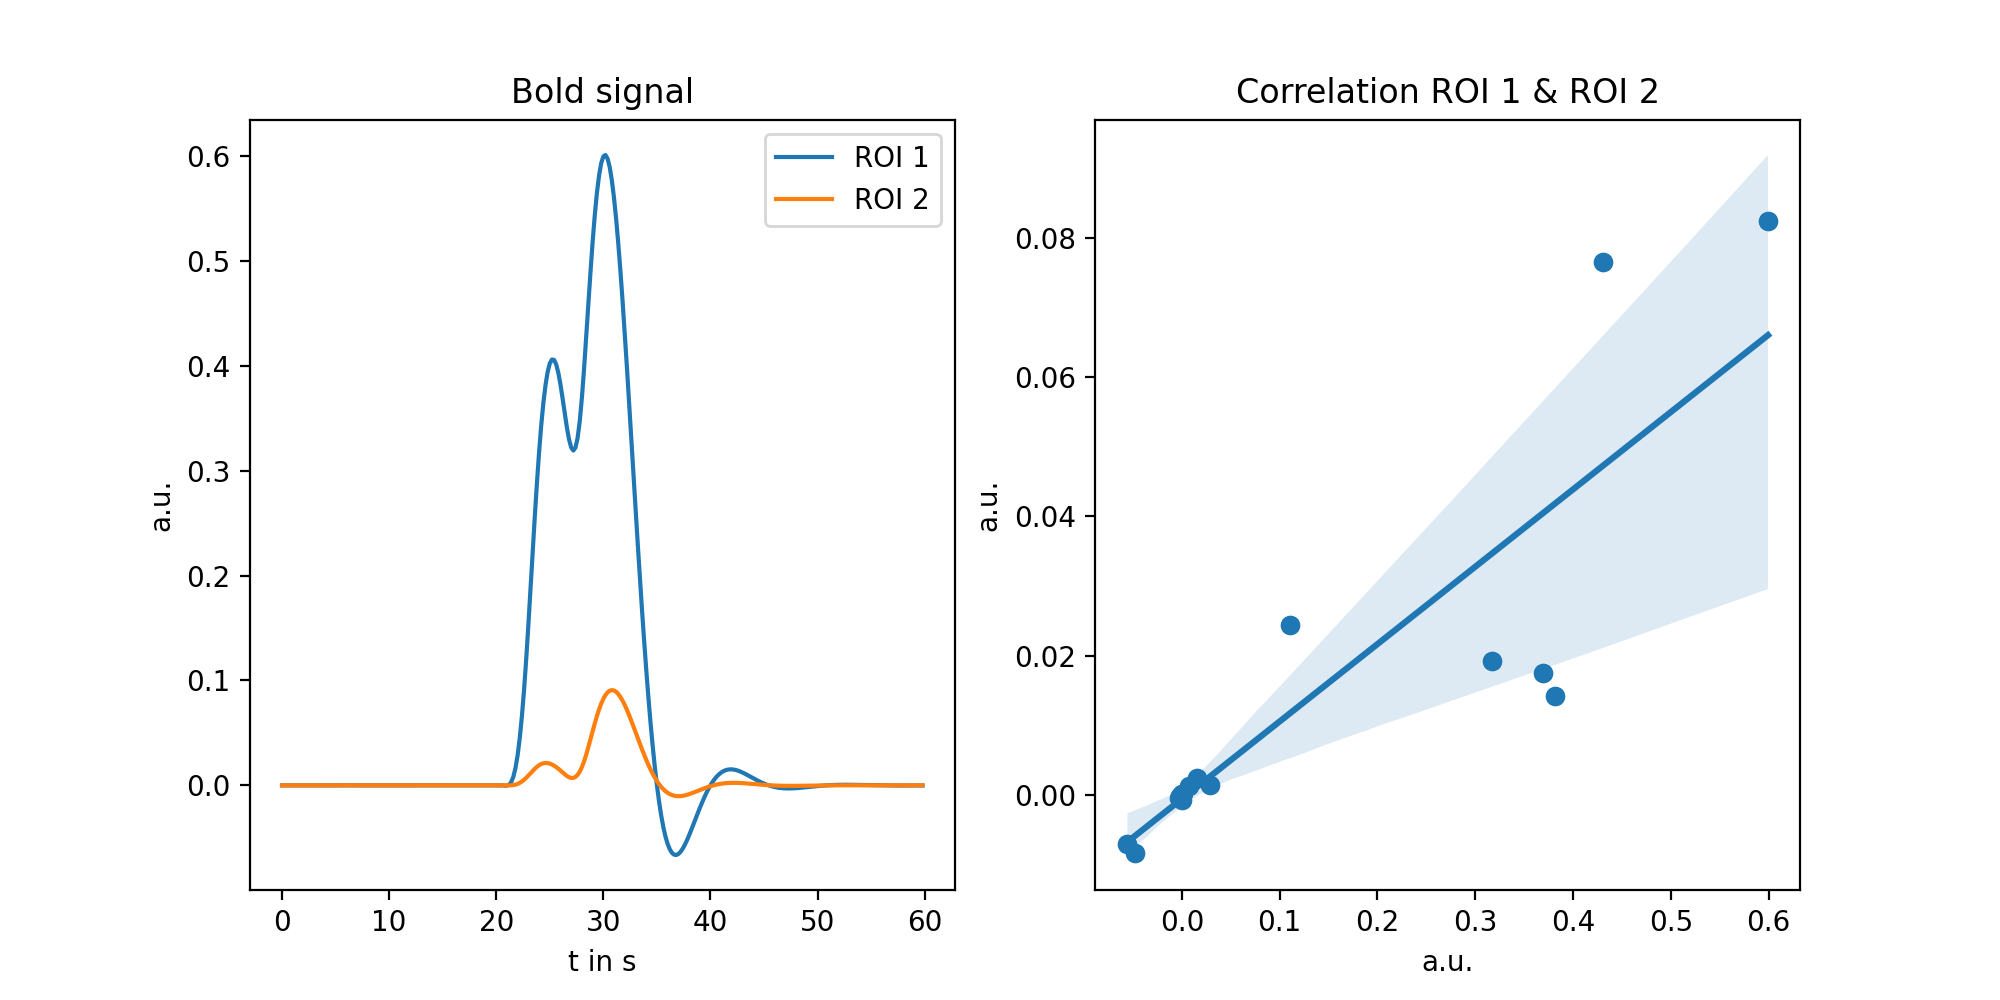

/var/folders/f1/xqrc55754_zc2fhhxw4zx1sc0000gn/T/ipykernel_11066/1866548945.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


In [10]:
%matplotlib notebook

corl = np.corrcoef(gx[0, tr_index].T, gx[1, tr_index].T)[0, 1]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(np.arange(gx.shape[1]) / decim * TR, gx[0:2, :].T)
axes[1].scatter(gx[0, tr_index].T, gx[1, tr_index].T)
sns.regplot(x=gx[0, tr_index].T, y=gx[1, tr_index].T, ax=axes[1])

axes[0].set(title='Bold signal', ylabel='a.u.', xlabel='t in s')
axes[0].legend(['ROI 1', 'ROI 2'])
axes[1].set(title=f'Correlation ROI 1 & ROI 2', xlabel='a.u.', ylabel='a.u.')
axes[1].text(0.5, -0.5, f'r={corl:4.2f}', size=12)
plt.tight_layout()


#plt.savefig('resting_state_example.png', bbox_inches='tight', transparent=True)
plt.show()